# Preprocessing & Modeling

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import scipy
from scipy.stats import boxcox
import seaborn as sns

import sklearn 
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [314]:
df = pd.read_csv('final_df.csv')

# converting market value to million
df['market_value_in_eur'] = df['market_value_in_eur'] / 1000000

# renaming column
#df.rename(columns={'market_value_in_eur': 'market_value_in_million_eur'}, inplace=True)

df.head()

,Unnamed: 0,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,Main Position,Season,player_id,last_season_x,date,market_value_in_eur,current_club_id_x,player_club_domestic_competition_id,name_x,current_club_id_y,player_code,position,sub_position,foot,image_url,current_club_domestic_competition_id,current_club_name,club_id,club_code,name_y,domestic_competition_id,competition_id,type,country_name
0,0,Adama Diakhaby,fr FRA,"FW,MF",Monaco,fr Ligue 1,21,

## Keeping Intended Variables (Not Feature Selection)

In [315]:
df = df.drop(columns=['Unnamed: 0', 'Nation', 'Pos', 'Squad', 'Born', 'Main Position', 'Season',
                     'player_id', 'last_season_x', 'date', 'current_club_id_x', 
                      'player_club_domestic_competition_id','name_x',
                      'current_club_id_y','player_code', 'sub_position', 'foot',
                      'image_url', 'current_club_domestic_competition_id', 'current_club_name', 
                      'club_id', 'club_code', 'name_y', 'domestic_competition_id', 'competition_id',
                     'type', 'country_name'])

df.head()

,Player,Comp,Age,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,market_value_in_eur,position
0,Adama Diakhaby,fr Ligue 1,21,22,10,850.00,2.00,2.70,2.00,14.00,4.00,28.60,1.48,0.42,0.14,0.50,16.30,0.00,0.00,0.00,2.00,2.00,0.14,0.00,0.00,140.00,214.00,65.40,2023.00,391.00,84.00,110.00,76.40,41.00,64.00,64.10,10.00,21.00,47.60,3.00,0.80,2.20,7.00,9.00,4.00,2.00,9.00,209.00,5.00,0.00,0.00,44.00,7.00,21.00,0.00,0.00,0.00,0.00,147.00,28.00,39.00,156.00,25.00,24.00,3.00,2.00,3.00,3.00,5.00,

In [226]:
list_a = df.columns
list_a[0:100]

Index(['Player', 'Comp', 'Age', 'MP', 'Starts', 'Min', 'npGoals', 'npxG+xA',
       'Goals', 'Shots', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT',
       'AvgShotDistance', 'FKShots', 'PK', 'PKsAtt', 'xG', 'npxG', 'npxG/Sh',
       'G-xG', 'npG-xG', 'PassesCompleted', 'PassesAttempted', 'TotCmp%',
       'TotalPassDist', 'ProgPassDist', 'ShortPassCmp', 'ShortPassAtt',
       'ShortPassCmp%', 'MedPassCmp', 'MedPassAtt', 'MedPassCmp%',
       'LongPassCmp', 'LongPassAtt', 'LongPassCmp%', 'Assists', 'xA', 'A-xA',
       'KeyPasses', 'Final1/3Cmp', 'PenAreaCmp', 'CrsPenAreaCmp', 'ProgPasses',
       'LivePass', 'DeadPass', 'FKPasses', 'ThruBalls', 'PassUnderPress',
       'Switches', 'Crs', 'CK', 'InSwingCK', 'OutSwingCK', 'StrCK', 'Ground',
       'Low', 'High', 'Left', 'Right', 'Head', 'ThrowIn', 'Other',
       'PassesToOff', 'PassesOOB', 'PassesInt', 'PassesBlocked', 'SCA',
       'SCA90', 'SCAPassLive', 'SCAPassDead', 'SCADrib', 'SCASh', 'SCAFld',
       'SCADef', 'GCA', 'GCA90'

## Encoding of Categorical Variables

In [316]:
#### Dummy Encoding. Using pandas library for this

df = pd.get_dummies(df, columns=['Comp', 'position'])
df.head(5)

,Player,Age,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,market_value_in_eur,Comp_de Bundesliga,Comp_eng Premier League,Comp_es La Liga,Comp_fr Ligue 1,Comp_it Serie A,position_Attack,position_Midfield
0,Adama Diakhaby,21,22,10,850.00,2.00,2.70,2.00,14.00,4.00,28.60,1.48,0.42,0.14,0.50,16.30,0.00,0.00,0.00,2.00,2.00,0.14,0.00,0.00,140.00,214.00,65.40,2023.00,391.00,84.00,110.00,76.40,41.00,64.00,64.10,10.00,21.00,47.60,3.00,0.80,2.20,7.00,9.00,4.00,2.00,9.00,209.00,5.00,0.00,0.00,

## Checking for Normality

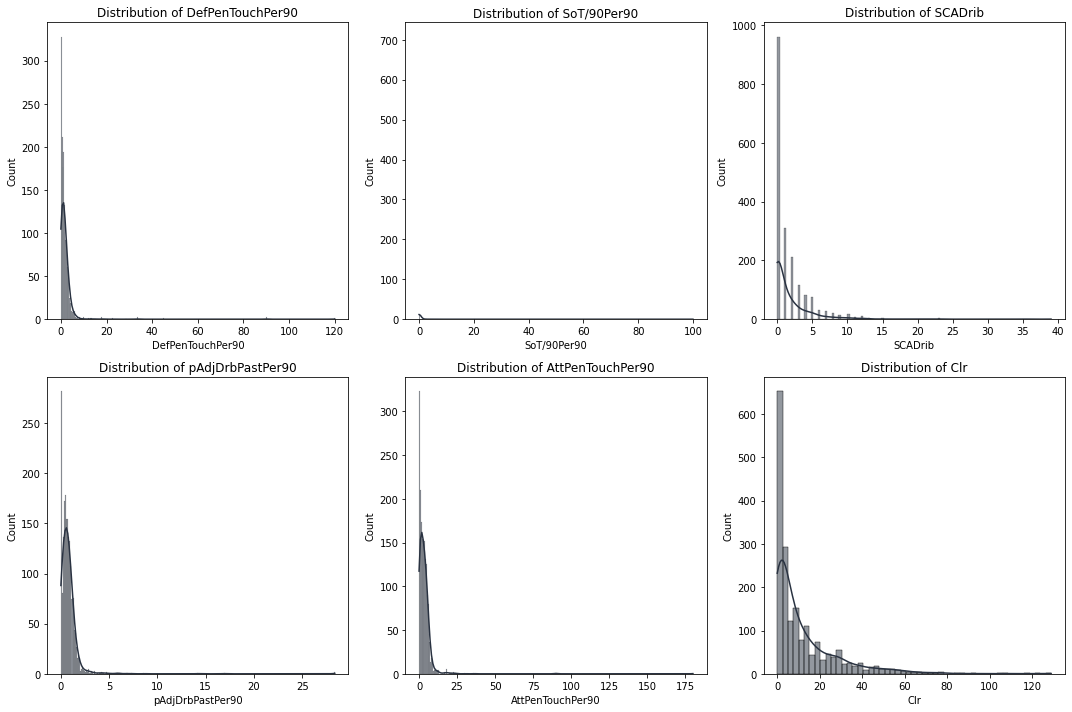

In [186]:
# selecting 6 random variables
random_variables = np.random.choice(df.columns, size=6, replace=False)

# creating subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plotting distributiosn
for i, ax in enumerate(axes.flat):
    if i < len(random_variables):
        sns.histplot(df[random_variables[i]], kde=True, ax=ax, color='#293241')
        ax.set_title(f'Distribution of {random_variables[i]}')

plt.tight_layout()

plt.savefig('/Users/enzovillafuerte/Desktop/Grad School/Data Science/Final Project/Images/normality_check.png')
plt.show()

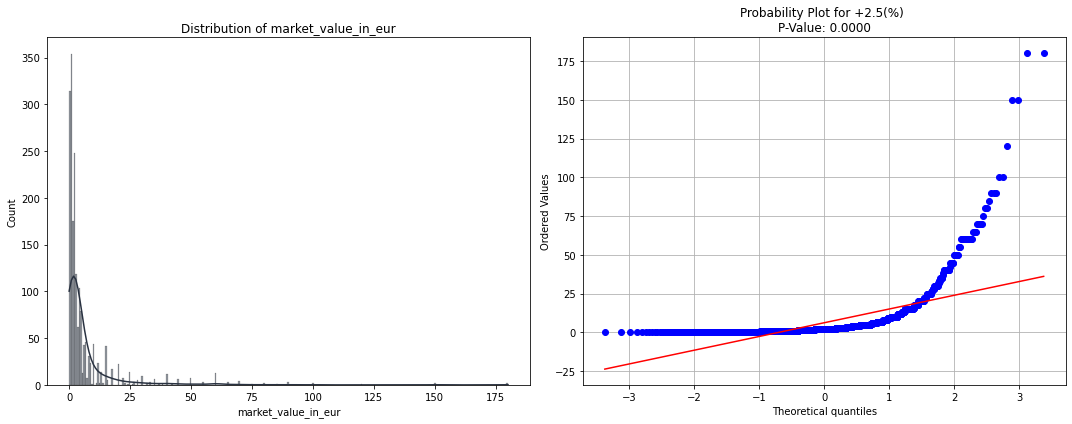

In [187]:
import scipy.stats as stats

# Plotting the distribution and probability plot for market_value_in_eur
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram and Kernel Density Estimate (KDE) plot for market_value_in_eur
sns.histplot(df['market_value_in_eur'], kde=True, ax=axes[0], color='#293241')
axes[0].set_title('Distribution of market_value_in_eur')

# Probability plot (QQ plot) for market_value_in_eur
stats.probplot(df['market_value_in_eur'], plot=axes[1])
axes[1].set_title(f'Probability Plot for +2.5(%) \nP-Value: {p_value:.4f}')
plt.grid(True)

plt.tight_layout()

plt.savefig('/Users/enzovillafuerte/Desktop/Grad School/Data Science/Final Project/Images/normality_check_market_value.png')
plt.show()


## Clustering and Standardization

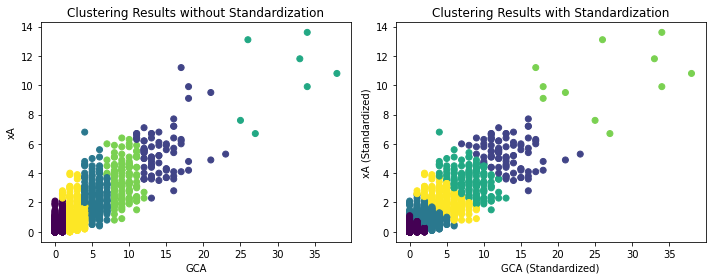

In [317]:
# crearting subset of the data for interested variables
X = df[['GCA', 'xA']]

# fitting model
kmeans_model = KMeans(n_clusters=6, random_state=42)
labels = kmeans_model.fit_predict(X)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# clustering with no standardization
axes[0].scatter(X['GCA'], X['xA'], c=labels, cmap='viridis')
axes[0].set_xlabel('GCA')
axes[0].set_ylabel('xA')
axes[0].set_title('Clustering Results without Standardization')

# standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

# fitting standardized model
kmeans_model = KMeans(n_clusters=6, random_state=42)
labels_scaled = kmeans_model.fit_predict(x_scaled)

axes[1].scatter(X['GCA'], X['xA'], c=labels_scaled, cmap='viridis')
axes[1].set_xlabel('GCA (Standardized)')
axes[1].set_ylabel('xA (Standardized)')
axes[1].set_title('Clustering Results with Standardization')

plt.tight_layout()
plt.savefig('/Users/enzovillafuerte/Desktop/Grad School/Data Science/Final Project/Images/kmeans-clustering.png')
plt.show()


### Standardization

In [318]:
# selecting subset of the data to standardize
df.columns
columns_to_standardize = df.columns.difference(['Player', 'market_value_in_eur', 'Comp_de Bundesliga', 'Comp_eng Premier League', 'Comp_es La Liga',
       'Comp_fr Ligue 1', 'Comp_it Serie A', 'position_Attack',
       'position_Midfield'])

# standardization
scaler = StandardScaler()
df_scaled = df.copy()  # creating copy 
df_scaled[columns_to_standardize] = scaler.fit_transform(df_scaled[columns_to_standardize])

In [323]:
# Standardization
scaler = StandardScaler()
df_scaled = df.copy()  # Creating a copy of the DataFrame

# Selecting subset of the data to standardize
columns_to_standardize = df.columns.difference(['Player', 'Comp_de Bundesliga', 'Comp_eng Premier League', 'Comp_es La Liga',
       'Comp_fr Ligue 1', 'Comp_it Serie A', 'position_Attack',
       'position_Midfield', 'market_value_in_eur'])

# Standardizing selected columns
df_scaled[columns_to_standardize] = scaler.fit_transform(df_scaled[columns_to_standardize])

# Rounding the standardized values in selected columns to 4 decimals
df_scaled[columns_to_standardize] = df_scaled[columns_to_standardize].round(decimals=4)

# creating frame for over 5 market value analysis
df_scaled_over_five = df_scaled[(df_scaled['market_value_in_eur']>= 5.0) & (df_scaled['market_value_in_eur']<= 80.0)]
df_scaled_over_five.to_csv('df_scaled_over_five.csv', index=False)

## Feature Selection - Boruta Algorithm

In [243]:
# moving target feature as the last column
# reordering columns
cols_except_market_value = [col for col in df_scaled.columns if col != 'market_value_in_eur']

new_cols_order = cols_except_market_value + ['market_value_in_eur']

# Reindex the DataFrame with the new column order
df_scaled = df_scaled.reindex(columns=new_cols_order)

df_scaled.to_csv('scaled_df.csv', index=False)

df_scaled.head()

,Player,Age,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,Comp_de Bundesliga,Comp_eng Premier League,Comp_es La Liga,Comp_fr Ligue 1,Comp_it Serie A,position_Attack,position_Midfield,market_value_in_eur
0,Adama Diakhaby,-1.06,0.41,-0.11,-0.18,0.07,-0.11,-0.01,-0.20,-0.26,0.10,-0.09,-0.14,0.66,1.25,0.10,-0.31,-0.27,-0.29,-0.04,0.04,0.84,0.08,0.08,-0.54,-0.50,-0.65,-0.58,-0.61,-0.45,-0.42,-0.28,-0.58,-0.54,-0.56,-0.56,-0.54,-0.25,0.91,-0.27,2.23,-0.37,-0.52,-0.46,-0.08,-0.63,-0.48,-0

In [310]:
# Not being able to make it work, reflect on discussion
''''
# moving target feature as the last column
# reordering columns
cols_except_market_value = [col for col in df_scaled.columns if col != 'market_value_in_eur']

new_cols_order = cols_except_market_value + ['market_value_in_eur']

# Reindex the DataFrame with the new column order
df_scaled = df_scaled.reindex(columns=new_cols_order)
df_scaled.head()

# keeping only the variables that the model read without errors
lista = df_scaled.columns[0:304].to_list() + ['market_value_in_eur']
df_scaled = df_scaled[lista]


X = df_scaled.drop(['market_value_in_eur', 'Player'], axis=1)

y = df_scaled['market_value_in_eur']

# Define the Random Forest model
rf = RandomForestRegressor(n_estimators=100) 

# Initialize Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta to the data
boruta.fit(X.values, y.values)

# Get selected features
selected_features = X.columns[boruta.support_].tolist()

# Print selected features
print("Selected features:", selected_features)

'''

#df_scaled.to_csv('scaled_df.csv', index=False)

'\'\n# moving target feature as the last column\n# reordering columns\ncols_except_market_value = [col for col in df_scaled.columns if col != \'market_value_in_eur\']\n\nnew_cols_order = cols_except_market_value + [\'market_value_in_eur\']\n\n# Reindex the DataFrame with the new column order\ndf_scaled = df_scaled.reindex(columns=new_cols_order)\ndf_scaled.head()\n\n# keeping only the variables that the model read without errors\nlista = df_scaled.columns[0:304].to_list() + [\'market_value_in_eur\']\ndf_scaled = df_scaled[lista]\n\n\nX = df_scaled.drop([\'market_value_in_eur\', \'Player\'], axis=1)\n\ny = df_scaled[\'market_value_in_eur\']\n\n# Define the Random Forest model\nrf = RandomForestRegressor(n_estimators=100) \n\n# Initialize Boruta\nboruta = BorutaPy(estimator=rf, n_estimators=\'auto\', verbose=2, random_state=42)\n\n# Fit Boruta to the data\nboruta.fit(X.values, y.values)\n\n# Get selected features\nselected_features = X.columns[boruta.support_].tolist()\n\n# Print selecte

## Modeling

In [202]:
'''
#df_scaled = pd.read_csv('scaled_df.csv')

# moving target feature as the last column
# reordering columns
cols_except_market_value = [col for col in df_scaled.columns if col != 'market_value_in_eur']

new_cols_order = cols_except_market_value + ['market_value_in_eur']

# Reindex the DataFrame with the new column order
df_scaled = df_scaled.reindex(columns=new_cols_order)
df_scaled.head()
'''

,Player,Age,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,Comp_de Bundesliga,Comp_eng Premier League,Comp_es La Liga,Comp_fr Ligue 1,Comp_it Serie A,position_Attack,position_Midfield,market_value_in_eur
0,Adama Diakhaby,-1.06,0.41,-0.11,-0.18,0.07,-0.11,-0.01,-0.20,-0.26,0.10,-0.09,-0.14,0.66,1.25,0.10,-0.31,-0.27,-0.29,-0.04,0.04,0.84,0.08,0.08,-0.54,-0.50,-0.65,-0.58,-0.61,-0.45,-0.42,-0.28,-0.58,-0.54,-0.56,-0.56,-0.54,-0.25,0.91,-0.27,2.23,-0.37,-0.52,-0.46,-0.08,-0.63,-0.48,-0

In [244]:
df_scaled

,Player,Age,MP,Starts,Min,npGoals,npxG+xA,Goals,Shots,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,AvgShotDistance,FKShots,PK,PKsAtt,xG,npxG,npxG/Sh,G-xG,npG-xG,PassesCompleted,PassesAttempted,TotCmp%,TotalPassDist,ProgPassDist,ShortPassCmp,ShortPassAtt,ShortPassCmp%,MedPassCmp,MedPassAtt,MedPassCmp%,LongPassCmp,LongPassAtt,LongPassCmp%,Assists,xA,A-xA,KeyPasses,Final1/3Cmp,PenAreaCmp,CrsPenAreaCmp,ProgPasses,LivePass,DeadPass,FKPasses,ThruBalls,PassUnderPress,Switches,Crs,CK,InSwingCK,OutSwingCK,StrCK,Ground,Low,High,Left,Right,Head,ThrowIn,Other,PassesToOff,PassesOOB,PassesInt,PassesBlocked,SCA,SCA90,SCAPassLive,SCAPassDead,SCADrib,SCASh,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef,DrbTkl,TklWinPoss,Def3rdPress,Mid3rdPress,Att3rdPress,DrbTkl.1,DrpPastAtt,DrbTkl%,DrbPast,Press,PressSucc,PressSucc%,Def3rdPress.1,Mid3rdPress.1,Att3rdPress.1,Blocks,ShBlocks,ShSvBlocks,PassBlocks,Int,Tkl+Int,Clr,Err,Touches,DefPenTouch,Def3rdTouch,Mid3rdTouch,Att3rdTouch,AttPenTouch,LiveTouch,SuccDrb,AttDrb,DrbSucc%,PlDrbPast,Megs,Carries,TotCarryDist,PrgCarryDist,ProgCarries,CarriesToFinal3rd,CarriesToPenArea,CarryMistakes,Disposesed,PassTarget,ReceivedPass,Receive%,ProgPassesRec,Yellows,Reds,Yellow2,Fls,Fld,Off,PKwon,PKcon,OG,Recov,AerialWins,AerialLoss,AerialWin%,npGoalsPer90,npxG+xAPer90,GoalsPer90,ShotsPer90,SoTPer90,SoT%Per90,Sh/90Per90,SoT/90Per90,G/ShPer90,G/SoTPer90,AvgShotDistancePer90,FKShotsPer90,PKPer90,PKsAttPer90,xGPer90,npxGPer90,npxG/ShPer90,G-xGPer90,npG-xGPer90,PassesCompletedPer90,PassesAttemptedPer90,TotCmp%Per90,TotalPassDistPer90,ProgPassDistPer90,ShortPassCmpPer90,ShortPassAttPer90,ShortPassCmp%Per90,MedPassCmpPer90,MedPassAttPer90,MedPassCmp%Per90,LongPassCmpPer90,LongPassAttPer90,LongPassCmp%Per90,AssistsPer90,xAPer90,A-xAPer90,KeyPassesPer90,Final1/3CmpPer90,PenAreaCmpPer90,CrsPenAreaCmpPer90,ProgPassesPer90,LivePassPer90,DeadPassPer90,FKPassesPer90,ThruBallsPer90,PassUnderPressPer90,SwitchesPer90,CrsPer90,CKPer90,InSwingCKPer90,OutSwingCKPer90,StrCKPer90,GroundPer90,LowPer90,HighPer90,LeftPer90,RightPer90,HeadPer90,ThrowInPer90,OtherPer90,PassesToOffPer90,PassesOOBPer90,PassesIntPer90,PassesBlockedPer90,SCAPer90,SCA90Per90,GCAPassLivePer90,GCAPassDeadPer90,GCADribPer90,GCAShPer90,GCAFldPer90,GCADefPer90,GCAPer90,GCA90Per90,GCAPassLive.1Per90,GCAPassDead.1Per90,GCADrib.1Per90,GCASh.1Per90,GCAFld.1Per90,GCADef.1Per90,DrbTklPer90,TklWinPossPer90,Def3rdPressPer90,Mid3rdPressPer90,Att3rdPressPer90,DrbTkl.1Per90,DrpPastAttPer90,DrbTkl%Per90,DrbPastPer90,PressPer90,PressSuccPer90,PressSucc%Per90,Def3rdPress.1Per90,Mid3rdPress.1Per90,Att3rdPress.1Per90,BlocksPer90,ShBlocksPer90,ShSvBlocksPer90,PassBlocksPer90,IntPer90,Tkl+IntPer90,ClrPer90,ErrPer90,TouchesPer90,DefPenTouchPer90,Def3rdTouchPer90,Mid3rdTouchPer90,Att3rdTouchPer90,AttPenTouchPer90,LiveTouchPer90,SuccDrbPer90,AttDrbPer90,DrbSucc%Per90,PlDrbPastPer90,MegsPer90,CarriesPer90,TotCarryDistPer90,PrgCarryDistPer90,ProgCarriesPer90,CarriesToFinal3rdPer90,CarriesToPenAreaPer90,CarryMistakesPer90,DisposesedPer90,PassTargetPer90,ReceivedPassPer90,Receive%Per90,ProgPassesRecPer90,YellowsPer90,RedsPer90,Yellow2Per90,FlsPer90,FldPer90,OffPer90,PKwonPer90,PKconPer90,OGPer90,RecovPer90,AerialWinsPer90,AerialLossPer90,AerialWin%Per90,90sPer90,AvgTeamPoss,OppTouches,TeamMins,TeamTouches90,pAdjTkl+IntPer90,pAdjPressSuccPer90,pAdjClrPer90,pAdjShBlocksPer90,pAdjIntPer90,pAdjDrbTklPer90,pAdjTklWinPossPer90,pAdjDrbPastPer90,pAdjAerialWinsPer90,pAdjAerialLossPer90,pAdjDrpPastAttPer90,TouchCentrality,Tkl+IntOppTouch,pAdjTouchesPer90,pAdjCarriesPer90,Comp_de Bundesliga,Comp_eng Premier League,Comp_es La Liga,Comp_fr Ligue 1,Comp_it Serie A,position_Attack,position_Midfield,market_value_in_eur
0,Adama Diakhaby,-1.06,0.41,-0.11,-0.18,0.07,-0.11,-0.01,-0.20,-0.26,0.10,-0.09,-0.14,0.66,1.25,0.10,-0.31,-0.27,-0.29,-0.04,0.04,0.84,0.08,0.08,-0.54,-0.50,-0.65,-0.58,-0.61,-0.45,-0.42,-0.28,-0.58,-0.54,-0.56,-0.56,-0.54,-0.25,0.91,-0.27,2.23,-0.37,-0.52,-0.46,-0.08,-0.63,-0.48,-0

In [311]:
df_scaled['market_value_in_eur'].describe()

count   1911.00
mean       6.26
std       13.64
min        0.05
25%        1.00
50%        2.00
75%        5.00
max      180.00
Name: market_value_in_eur, dtype: float64

In [313]:
df_scaled_over_five = df_scaled[df_scaled['market_value_in_eur']>= 5.0]
df_scaled_over_five.to_csv('df_scaled_over_five.csv', index=False)

### Simple Linear Regression

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

'''
df_scaled = pd.read_csv('scaled_df.csv')


# moving target feature as the last column
# reordering columns
cols_except_market_value = [col for col in df_scaled.columns if col != 'market_value_in_eur']

new_cols_order = cols_except_market_value + ['market_value_in_eur']

# Reindex the DataFrame with the new column order
df_scaled = df_scaled.reindex(columns=new_cols_order)
df_scaled.head()

'''
###################### IF BEING ABLE TO FIX THE PROBLEM JUST DEELTE THE FOLLOWING ######################
# keeping only the variables that the model read without errors
lista = df_scaled.columns[0:304].to_list() + ['market_value_in_eur']
df_scaled = df_scaled[lista]
##############################################################################################################


# dropping metadata (Player) - features that are irrelevant for modeling purposes
linear_df = df_scaled.drop(['Player'], axis=1)

# defining target and predictor variables
y = linear_df['market_value_in_eur']
X = linear_df.drop(['market_value_in_eur'], axis=1)

# spliting intro training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("Feature size (Training):", X_train.shape, '\nResponse size (training)', y_train.shape,
      "\nFeature size (Test):", X_test.shape, "\nResponse size (Test):", y_test.shape)


# fitting the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate the MSE of the training set
# Predict the responses using the test set and find the MSE for the test set
# 5 pts

y_pred = lr.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("The mean squared error (MSE) is:", mean_squared_error(y_test, y_pred))
print("The mean absolute error (MAE) is:", mean_absolute_error(y_test, y_pred))
print("The root mean squared error (RMSE) is:", np.sqrt(mean_squared_error(y_test, y_pred)))

Feature size (Training): (1337, 303) 
Response size (training) (1337,) 
Feature size (Test): (574, 303) 
Response size (Test): (574,)
The mean squared error (MSE) is: 146.14991152994168
The mean absolute error (MAE) is: 7.381757532988524
The root mean squared error (RMSE) is: 12.089247765264044


### Cross Validation Simple LR

In [255]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

################ INITIALIZING CROSS VALIDATION ###########
##### cross_val_score package used according to the book ####
kf = KFold(n_splits=10, shuffle=True, random_state=42)

################ INITIALIZING K (10) FOLD CROSS VALIDATION ###########
##### Focusing on the MAE, why? because of the nature of the target feature, presence of outliers and skewed distribution
scores_10 = cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mae_scores_10 = -scores_10
### Average
avg_mae_10 = mae_scores_10.mean()

print("Average MAE for Linear Regression:", avg_mae_10)

Average MAE for Linear Regression: 7.737219055353821


### Ridge Regression

In [275]:
from sklearn.linear_model import Ridge

########################## RIDGE REGRESSION
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# different values for penalization parameter
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400]

for var in alphas:
    
    #initializing ridge regression and pre-defining alpha value
    ridge=Ridge(alpha=var, solver='svd')
    ridge.fit(X_train, y_train)
    
    #k (10) fold cross validation
    ridge_scores = cross_val_score(ridge, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    ridge_mse_scores = -ridge_scores
    
    # average MSE
    avg_mse = ridge_mse_scores.mean()
    
    # printing output
    print(f'Average MAE - Ridge Regression (Alpha: {var}): {avg_mse}')
    #print(ridge_scores)

Average MAE - Ridge Regression (Alpha: 0.001): 7.7681867455805484
Average MAE - Ridge Regression (Alpha: 0.01): 7.532597787624515
Average MAE - Ridge Regression (Alpha: 0.1): 6.971694342480204
Average MAE - Ridge Regression (Alpha: 1): 6.327869792775807
Average MAE - Ridge Regression (Alpha: 10): 5.8293903850123225
Average MAE - Ridge Regression (Alpha: 100): 5.337531274406975
Average MAE - Ridge Regression (Alpha: 200): 5.189608176443801
Average MAE - Ridge Regression (Alpha: 300): 5.1105551070110105
Average MAE - Ridge Regression (Alpha: 400): 5.0693811806059


In [294]:
#initializing ridge regression and pre-defining alpha value 
# make sure to explain why alpha 200 (through bias and variance tradeoff)
ridge=Ridge(alpha=200, solver='svd')
ridge.fit(X_train, y_train)

######### Training
y_predict_ridge = ridge.predict(X_train)
mae_ridge = sklearn.metrics.mean_absolute_error(y_train, y_predict_ridge)
print(f'Training MAE - Ridge Regression: {mae_ridge}')


######### Testing
y_pred_test = ridge.predict(X_test)
mae_test = sklearn.metrics.mean_absolute_error(y_test, y_pred_test)
print(f'MAE on Test Dataset: {mae_test}')

Training MAE - Ridge Regression: 4.567744304054881
MAE on Test Dataset: 5.933832707387577


### Lasso Regression

In [289]:
import warnings


warnings.filterwarnings("ignore", category=Warning)

from sklearn.linear_model import Lasso

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

for var in alphas:
    
    #initializing ridge regression and pre-defining alpha value
    lasso=Lasso(alpha=var)
    lasso.fit(X_train, y_train)
    
    #k (10) fold cross validation
    lasso_scores = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    lasso_mse_scores = -lasso_scores
    
    # average MSE
    avg_mse = lasso_mse_scores.mean()
    
    # printing output
    print(f'Average MAE - Lasso Regression (Alpha: {var}): {avg_mse}')
    #print(ridge_scores)


Average MAE - Lasso Regression (Alpha: 0.001): 6.938648833921998
Average MAE - Lasso Regression (Alpha: 0.01): 5.789326876045614
Average MAE - Lasso Regression (Alpha: 0.1): 5.157465764829773
Average MAE - Lasso Regression (Alpha: 1): 4.97006134260561
Average MAE - Lasso Regression (Alpha: 10): 6.649084184264166
Average MAE - Lasso Regression (Alpha: 100): 6.649084184264166


In [295]:
lasso = Lasso(alpha=1).fit(X_train, y_train)

###### Training
y_predict_lasso = lasso.predict(X_train)
mae_lasso = sklearn.metrics.mean_absolute_error(y_train, y_predict_lasso)
print(f'Training MAE - Lasso Regression: {mae_lasso}')

###### Testing
y_pred_test = lasso.predict(X_test)

mae_test = sklearn.metrics.mean_absolute_error(y_test, y_pred_test)

print(f'MAE on Test Dataset: {mae_test}')

Training MAE - Lasso Regression: 4.823652839333915
MAE on Test Dataset: 5.486775667266365


## Random Forest Regressor

In [307]:
from sklearn.ensemble import RandomForestRegressor

##################### RANDOM FOREST REGRESSOR ######################

# initializing random forest
# number of estimators refer to the number of trees
rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)

# trainimng on training data
rf_regressor.fit(X_train, y_train)

############## predictions on TRAINING data
y_pred_train = rf_regressor.predict(X_train)

# evaluation metric for training
mae_training = mean_absolute_error(y_train, y_pred_train)


############## predictions on TESTING data
y_pred_test = rf_regressor.predict(X_test)

#evaluation metrics - testing data
mae_testing = mean_absolute_error(y_test, y_pred_test)

print("Mean Absolute Error (Training):", mae_training)
print("Mean Absolute Error (Testing):", mae_testing)

Mean Absolute Error (Training): 1.4843543207478136
Mean Absolute Error (Testing): 4.1890797652985805


In [304]:
# seeing a significant differnce between Training and Testing errors, 
# indicating overfitting of the training data
# We check do cross-validation | cross-validation error similar to testing
# feature selection would be ideal here, no time, put it in discussion

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# defining the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150, 200]  # Adjust as needed
}

# initializing the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# initializing cross validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

# training data
grid_search.fit(X_train, y_train)

# best hyperparameter
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# making predictions
y_pred_test = best_estimator.predict(X_test)

#model performance
mae_testing = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (Testing):", mae_testing)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mean Absolute Error (Testing): 4.177200044119644


## kNN

In [309]:
from sklearn.neighbors import KNeighborsRegressor

##################### K NEAREST NEIGHBORS CLASSIFIER ######################
## trying different neighbors and see which one gives the best performance

#### K=10 
knn_10 = KNeighborsRegressor(n_neighbors=10)
knn_10.fit(X_train, y_train)
y_pred_knn_10 = knn_10.predict(X_test)

#### K=20 
knn_20 = KNeighborsRegressor(n_neighbors=20)
knn_20.fit(X_train, y_train)
y_pred_knn_20 = knn_20.predict(X_test)

#### K=50
knn_50 = KNeighborsRegressor(n_neighbors=50)
knn_50.fit(X_train, y_train)
y_pred_knn_50 = knn_50.predict(X_test)

#### K=5
knn_5 = KNeighborsRegressor(n_neighbors=5)
knn_5.fit(X_train, y_train)
y_pred_knn_5 = knn_5.predict(X_test)

##################### Function for MAE Analysis ######################
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error (MAE):", mae)
    return mae

##################### Results ######################

print("Metrics for k=10:")
mae_knn_10 = regression_metrics(y_test, y_pred_knn_10)

##### Best Model:
print("\nMetrics for k=20:")
mae_knn_20 = regression_metrics(y_test, y_pred_knn_20)

print("\nMetrics for k=50:")
mae_knn_50 = regression_metrics(y_test, y_pred_knn_50)

print("\nMetrics for k=5:")
mae_knn_5 = regression_metrics(y_test, y_pred_knn_5)

Metrics for k=10:
Mean Absolute Error (MAE): 4.480396341463415

Metrics for k=20:
Mean Absolute Error (MAE): 4.460790505226481

Metrics for k=50:
Mean Absolute Error (MAE): 4.581983449477352

Metrics for k=5:
Mean Absolute Error (MAE): 4.763702090592334
